(Note that all units unless otherwise mentioned are SI units.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from multislice import prop,prop_utils

Importing all the required libraries.

step_xy 2.00040008002e-08
energy(in eV) 5000
wavelength in m 2.47968e-10
focal_length 0.006
zp_coords (-50, 50, -50, 50)
delta 0.00012143
beta 2.6233e-05


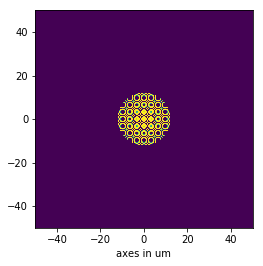

In [2]:
zp = np.load('zp.npy')
parameters = pickle.load(open('parameters.pickle','rb'))
for i in parameters : print(i,parameters[i])
zp_coords = parameters['zp_coords']
plt.imshow(zp,extent=zp_coords)
plt.xlabel('axes in um')
plt.show()

Importing zone plate pattern and the parameters associated with it.

In [3]:
zp_beta  = parameters['beta']*zp
zp_delta = parameters['delta']*zp
step_xy = parameters['step_xy']
energy = parameters['energy(in eV)']
wavel = parameters['wavelength in m']
f = parameters['focal_length']
wavefront = np.ones(np.shape(zp),dtype='complex64') 
L = step_xy*np.shape(zp)[0] 
m,n = np.shape(zp)
zp_thickness = 1000e-9      

*Setting up the parameters for the simulation*<br>
* *zp_beta and zp_delta* : delta and beta grid for the zone plate <br>
* *step_xy*              : sampling in the xy plane<br>
* *wavel*                : wavelength<br>
* *f*                    : focal length<br>
* *wavefront*            : wavefront that is initialzed with magnitude of 1 and phase of 0<br>
* *L*                    : support length<br>
* *m,n*                  : dimensions of input zp<zp>
* *zp_thickness*         : thickness of zone plate <br>

In [4]:
theta = 0.05*(np.pi/180)
slope = np.tan(theta)
x = np.linspace(zp_coords[0]*1e-6,zp_coords[1]*1e-6,n)
X,Y = np.meshgrid(x,x)
z1 = 2*np.pi*(1/wavel)*slope*X
wave_in = np.multiply(np.ones((n,n),dtype='complex64'),np.exp(1j*(z1)))

*creating the input wave*<br>
* *theta*   : tilt angle <br>
* *slope*   : tangent of the tilt angle<br>
* *x*       : axis in the x direction<br>
* *X*       : 2D grid containing the x-coordinate of every point on the grid<br>
* *z1*      : phase of the plane wave calculated accoring to the distance traveled<br>
* *wave_in* : input wavefront with phase in accordance with the tilt

In [5]:
number_of_steps_zp =  prop_utils.number_of_steps(step_xy,wavel,zp_thickness)
wave_focus = prop_utils.propogate_through_object(wave_in,zp_delta,zp_beta,zp_thickness,step_xy,
                                                 wavel,L,number_of_steps_zp,d1=0,d2=f, xray_object='Zone Plate')

suggested step size : 1.61375680738e-05
number of steps required for propogation through the zone plate : 2
propogator to be used : TF


Propogation through Zone Plate...: 100%|██████████| 2/2 [00:40<00:00, 20.05s/it]


Free space propogation after Zone Plate...
propogator to be used : TF
Fresnel Number : 6.72398669743e-09


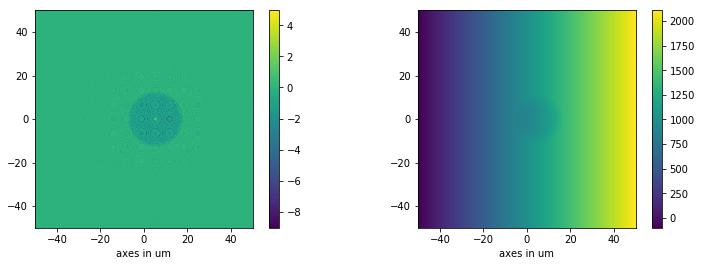

magnitude(in log scale)(left) and phase(right) of the focal_plane: 
maximum value of focal_plane:  142.160386624
minimum value of focal_plane:  0.000120991606598
location of maxima in focal_plane:  (array([2499, 2500]), array([2761, 2761]))


In [6]:
prop_utils.plot_2d_complex(wave_focus,mode='log',name='focal_plane',coords=zp_coords)

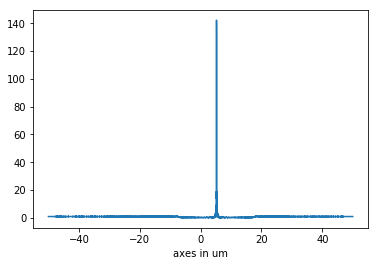

slice in x-direction along the focal spot


In [7]:
x = np.linspace(zp_coords[0],zp_coords[1],n)
plt.plot(x,abs(wave_focus)[2500,:])
plt.xlabel('axes in um')
plt.show()
print('slice in x-direction along the focal spot')